In [1]:
!pip install opencv-python
!pip install torch

In [2]:
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf

In [3]:
Learning_Rate = 1e-5
width = height = 800  # image width and height
batchSize = 3

In [4]:
TrainFolder = "LabPics/Simple/Train//"
ListImages = os.listdir(os.path.join(TrainFolder, "Image"))

In [5]:
transformImg = tf.Compose([tf.ToPILImage(), tf.Resize((height, width)), tf.ToTensor(),
                           tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transformAnn = tf.Compose([tf.ToPILImage(), tf.Resize((height, width)), tf.ToTensor()])

The code snippet defines two transformation pipelines using PyTorch's `torchvision.transforms` module.

The first transformation pipeline, transformImg, is used to preprocess images. It consists of four transformations:

1. tf.ToPILImage(): This transformation converts the input image, which is in tensor format, to a PIL image.
2. tf.Resize((height,width)): This transformation resizes the image to the specified height and width.
3. tf.ToTensor(): This transformation converts the PIL image to a tensor.
4. tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)): This transformation normalizes the tensor by subtracting the mean (0.485, 0.456, 0.406) and dividing by the standard deviation (0.229, 0.224, 0.225) for each channel. This normalization is commonly used for pre-trained image classification models like VGG, ResNet, and MobileNet.

The second transformation pipeline `transformAnn` is used to preprocess annotations. It consists of three transformations:

1. tf.ToPILImage(): This transformation converts the input annotation, which is in tensor format, to a PIL image.
2. tf.Resize((height,width)): This transformation resizes the annotation to the specified height and width.
3. tf.ToTensor(): This transformation converts the PIL image to a tensor.

Both pipelines can be applied to a batch of images and annotations using the `torch.utils.data.DataLoader` class.

In [6]:
def ReadRandomImage():
    idx = np.random.randint(0, len(ListImages))  # Pick random image
    img = cv2.imread(os.path.join(TrainFolder, "Image", ListImages[idx]))

    filled = cv2.imread(os.path.join(TrainFolder, "Semantic/16_Filled", ListImages[idx].replace("jpg", "png")), 0)
    vessel = cv2.imread(os.path.join(TrainFolder, "Semantic/1_Vessel", ListImages[idx].replace("jpg", "png")), 0)

    ann_map = np.zeros(img.shape[0:2], np.float32)  # Segmentation map

    if vessel is not None:
        ann_map[vessel == 1] = 1

    if filled is not None:
        ann_map[filled == 1] = 2

    img = transformImg(img)
    ann_map = transformAnn(ann_map)

    return img, ann_map

In [7]:
def LoadBatch():  # Load batch of images
    images = torch.zeros([batchSize, 3, height, width])
    ann = torch.zeros([batchSize, height, width])

    for i in range(batchSize):
        images[i], ann[i] = ReadRandomImage()

    return images, ann

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)  # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))  # Change final layer to 3 classes
Net = Net.to(device)

optimizer = torch.optim.Adam(params=Net.parameters(), lr=Learning_Rate)  # Create adam optimizer

Using GPU


C:\Users\Video-gamer\Projects\Segmentation_cnn\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Video-gamer\Projects\Segmentation_cnn\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
for itr in range(10000):  # Training loop
    print("Training [%4d/%d] " % (itr, 10000), end="")

    images, ann = LoadBatch()  # Load taining batch
    print(".", end="")

    # Load image
    images = torch.autograd.Variable(images, requires_grad=False).to(device)
    print(".", end="")

    # Load annotation
    ann = torch.autograd.Variable(ann, requires_grad=False).to(device)
    print(".", end="")

    # make prediction
    Pred = Net(images)['out']
    print(".", end="")

    Net.zero_grad()
    print(".", end="")

    # Set loss function
    criterion = torch.nn.CrossEntropyLoss()
    print(".", end="")

    # Calculate cross entropy loss
    Loss = criterion(Pred, ann.long())
    print(".", end="")

    # Backpropogate loss
    Loss.backward()
    print(".", end="")

    # Apply gradient descent change to weight
    optimizer.step()
    print(".", end="")

    # Get  prediction classes
    seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()
    print(".", end="")

    # Print loss
    print(itr, ") Loss=", Loss.data.cpu().numpy(), end="")

    # Save model every 1000 iterations to .torch file
    if itr % 1000 == 0:
        print(" - Saving Model" + str(itr) + ".torch")
        torch.save(Net.state_dict(), "torches\\" + str(itr) + ".torch")
    else:
        print("")

Training [   0/10000] ..........0 ) Loss= 1.1146412 - Saving Model0.torch
Training [   1/10000] ..........1 ) Loss= 1.0547378
Training [   2/10000] ..........2 ) Loss= 1.1281569
Training [   3/10000] ..........3 ) Loss= 1.1044791
Training [   4/10000] ..........4 ) Loss= 1.0876601
Training [   5/10000] ..........5 ) Loss= 1.03734
Training [   6/10000] ..........6 ) Loss= 1.0564982
Training [   7/10000] ..........7 ) Loss= 1.0587741
Training [   8/10000] ..........8 ) Loss= 1.1082567
Training [   9/10000] ..........9 ) Loss= 1.0310553
Training [  10/10000] ..........10 ) Loss= 1.0465515
Training [  11/10000] ..........11 ) Loss= 1.0407495
Training [  12/10000] ..........12 ) Loss= 1.0501089
Training [  13/10000] ..........13 ) Loss= 1.0043029
Training [  14/10000] ..........14 ) Loss= 1.0105424
Training [  15/10000] ..........15 ) Loss= 1.0253922
Training [  16/10000] ..........16 ) Loss= 1.0034077
Training [  17/10000] ..........17 ) Loss= 1.0082889
Training [  18/10000] ..........18 )

KeyboardInterrupt: 

# Testing

In [11]:
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt

In [10]:
modelPath = "torches/7000.torch"  # Path to model
imagePath = "test.jpg"  # Test image
height = width = 900

In [13]:
transformImg = tf.Compose([tf.ToPILImage(), tf.Resize((height, width)), tf.ToTensor(),
                           tf.Normalize((0.485, 0.456, 0.406),
                                        (0.229, 0.224, 0.225))])  # tf.Resize((300,600)),tf.RandomRotation(145)])#

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # Check if there is GPU if not set trainning to CPU (very slow)

In [15]:
Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)  # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))  # Change final layer to 3 classes
Net = Net.to(device)  # Set net to GPU or CPU
Net.load_state_dict(torch.load(modelPath))  # Load trained model
Net.eval()  # Set to evaluation mode

C:\Users\Video-gamer\Projects\Segmentation_cnn\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Video-gamer\Projects\Segmentation_cnn\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [16]:
Img = cv2.imread(imagePath)  # load test image
height_orgin, widh_orgin, d = Img.shape  # Get image original size

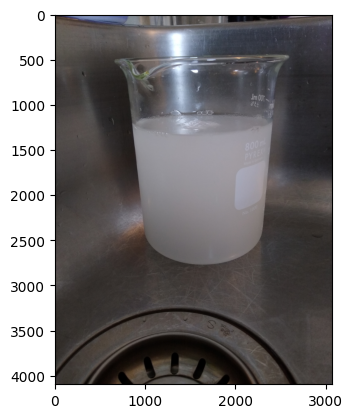

In [17]:
plt.imshow(Img[:, :, ::-1])  # Show image
plt.show()
Img = transformImg(Img)  # Transform to pytorch

C:\Users\Video-gamer\Projects\Segmentation_cnn\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


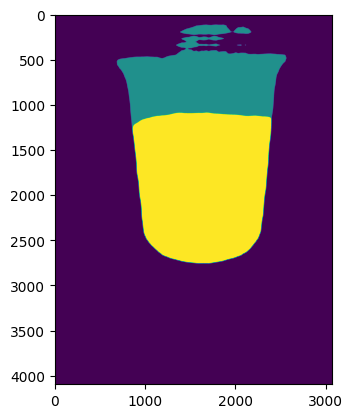

In [18]:
Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)
with torch.no_grad():
    Prd = Net(Img)['out']  # Run net
Prd = tf.Resize((height_orgin, widh_orgin))(Prd[0])  # Resize to origninal size
seg = torch.argmax(Prd, 0).cpu().detach().numpy()  # Get  prediction classes
plt.imshow(seg)  # display image
plt.show()